![Predicting concrete strength](img/Title.png)

<p style="font-size:30px;text-align:center;color:rgba(103,111,121,255)">Predicting concrete strength</p>
<p style="font-size:20px;text-align:center;color:rgba(103,111,121,255)">DataCamp&#174; Competition</p>
<p style="font-size:10px;text-align:center;color:rgba(103,111,121,255)">Spring 2022</p>

<h1>0-Introduction and Initialization</h1>

Concrete is a composite material composed of fine and coarse aggregate bonded together with a fluid cement (cement paste) that hardens (cures) over time. Concrete is the second-most-used substance in the world after water, and is the most widely used building material. Its usage worldwide, ton for ton, is twice that of steel, wood, plastics, and aluminum combined.Globally, the ready-mix concrete industry, the largest segment of the concrete market, is projected to exceed $600 billion in revenue by 2025.<br>
Based on DataCamp Competition , we have a dataset from concrete sample with different amount of essential factor and their strength. we need to build a linear model for predicting average strength of an entered sample after 1, 7, 14 ,28 days.    

⬇Libraries

In [1]:
%%capture
#libraries

import pandas as pd
import numpy as np
import warnings

#for the Plots

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

#for statistical computation

from scipy.stats import pearsonr
#for M.L

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
!pip install wordcloud
from wordcloud import WordCloud
from xgboost import XGBRegressor

#for css Power🎨

from IPython.core.display import HTML


# Environment check
warnings.filterwarnings('ignore')


📌 My Functions & Classes:<br><br>
in the below cell I imported a few useful functions and classes. Some of them are my works and the others has been copied 🙈. 


Notebook Color Scheme:


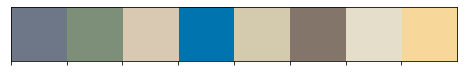

In [2]:
#-----------Import Css Style-------------

def css_styling():
    '''This function enable us to have beautiful alert cell inside our notebook '''
    styles = open("alert.css", "r").read()
    return HTML("<style>"+styles+"</style>")
css_styling()

# ----------- Plot values on bars ----------------
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()-0.2
                value = round(p.get_width()*100,2)
                ax.text(_x, _y, format(value, ','), ha="left",fontsize=20)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

#--------Outliers remover class----------

### This is my work.
### with this class, you can remove outlier from your dataframe.
### by its default, the values more than 3*Standard Deviation consider as outliers 
### and you can change it with "by" argument in init function.

from sklearn.base import BaseEstimator, TransformerMixin
class RemoveOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, by=3):
        self.by = by
        self.cut_off={}
        self.mean={}
    def fit(self, X, y=None):
        for col in X.columns:
            mean=X[col].mean()
            std =X[col].std()
            self.mean[col]=mean
            self.cut_off[col]=std*self.by
        return self
    def transform(self, X, y=None):
     
        for col in X.columns:
            lower,upper=self.mean[col]-self.cut_off[col],self.mean[col]+self.cut_off[col]
            
            X=X[(X[col]<upper)&(X[col]>lower)]
            
        return X
    
# Run cross validate Base on your pipeline and see results:

def cross_validate_pipline(Pipeline,X,y):
    cv_result_dict=cross_validate(Pipeline,X,y,cv=5,scoring=["neg_mean_squared_error","r2"])
    cv_result=np.sqrt(cv_result_dict["test_neg_mean_squared_error"]*-1)
    print(clr.S+"The Average Root Mean Squared Error (RMSE)Is:"+clr.E, 
      round(np.mean(cv_result),2),clr.S+"and R2 Score:"+clr.E,
      round(np.mean(np.abs(cv_result_dict["test_r2"])),2),clr.S+ "With "+Pipeline["model"].__class__.__name__+clr.E+"\n")
    
# Custom colors
class clr:
    S = '\033[1m' + '\033[90m'
    E = '\033[0m'
my_colors = ["#6e7788", "#7d8f79", "#d9c9b2", "#0074ae", "#d4caae" ,"#84756a","#e5deca","#f7d89a"]
sns.palplot(sns.color_palette(my_colors))
print(clr.S+"Notebook Color Scheme:"+clr.E)
plt.show()

<h1>1-The Data & EDA</h1>

In [3]:
#Read Data in DataFrame
df=pd.read_csv("data/concrete_data.csv")
df.head(5)

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [4]:
print(clr.S+"The dataset has a size of:"+clr.E, df.shape, "\n")

print(clr.S+"Missing values:"+clr.E)
df.isna().sum()

The dataset has a size of: (1030, 9) 

Missing values:


cement              0
slag                0
fly_ash             0
water               0
superplasticizer    0
coarse_aggregate    0
fine_aggregate      0
age                 0
strength            0
dtype: int64

<div class="alert simple-alert">
  <p>💡<b>Note</b>: Great News!!! It seems that don't have missing values 🎉</p
</div>


<div class="alert simple-alert">
  <p>👌 let's see distribution of each field and take a note about each one</p>
</div>

<h2>1-1 Cement (kg/m<sup>3</sup>)</h2>

![Predicting concrete strength](img/Cement.jpg)

📝 It has almost normal shape, mean and median(50%) are too close.It has not zero value.

In [5]:
df["cement"].describe()

count    1030.000000
mean      281.165631
std       104.507142
min       102.000000
25%       192.375000
50%       272.900000
75%       350.000000
max       540.000000
Name: cement, dtype: float64

In [6]:
print(clr.S+"Zero values:"+clr.E)
sum(list(df['cement']==0))

Zero values:


0

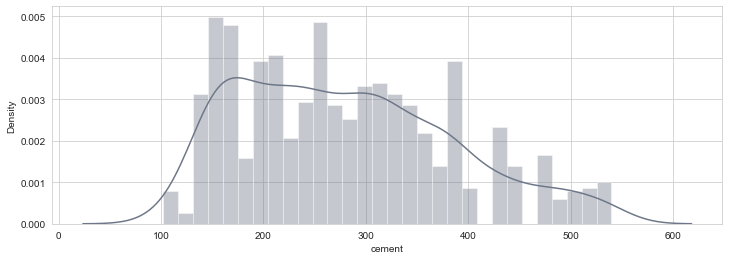

In [7]:
sns.set_style('whitegrid')
plt.figure(figsize = (12,4))
sns.distplot(a = df['cement'], bins = 30, norm_hist=False, kde=True, color = my_colors[0])

<h2>1-2 Blast Furnace Slag (kg/m<sup>3</sup>)</h2>

![Predicting concrete strength](img/slag.png)

📝 It has left skewed distribution and many zeros.mean and median(50%) are far away because of zeros. 

In [8]:
df['slag'].describe()

count    1030.000000
mean       73.895485
std        86.279104
min         0.000000
25%         0.000000
50%        22.000000
75%       142.950000
max       359.400000
Name: slag, dtype: float64

In [9]:
print(clr.S+"Zero values:"+clr.E)
sum(list(df['slag']==0))

Zero values:


466

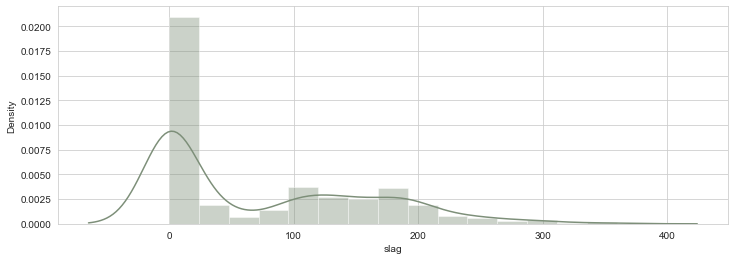

In [10]:
#plot with Zeros
plt.figure(figsize = (12,4))
sns.distplot(a = df['slag'], bins = 15, norm_hist=False, kde=True, color = "#7d8f79")

📝If we remove zeros from disturbution, we have almost normal one. mean and median(50%) are too close.
may be we should consider zeros as null Value🤔

In [11]:
df[df['slag']!=0]['slag'].describe()

count    564.000000
mean     134.950975
std       73.153836
min        0.020000
25%       94.700000
50%      133.850000
75%      189.000000
max      359.400000
Name: slag, dtype: float64

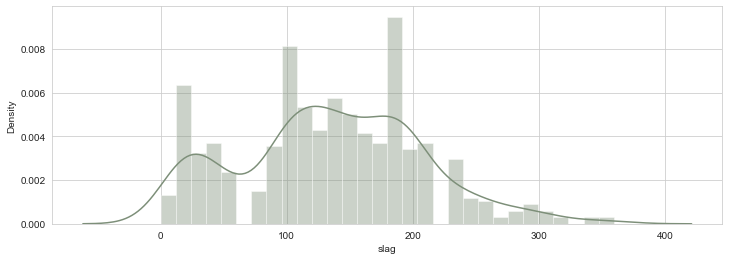

In [12]:
#plot without Zeros
plt.figure(figsize = (12,4))
sns.distplot(a = df[df['slag']!=0]['slag'], bins = 30, norm_hist=False, kde=True, color = "#7d8f79")

<h2>1-3 Fly Ash (kg/m<sup>3</sup>)</h2>

![Predicting concrete strength](img/fly-ash.jpg)

📝 It has left skewed distribution and many too zeros.mean and median(50%) are far away because of zeros. 

In [13]:
df['fly_ash'].describe()

count    1030.000000
mean       54.187136
std        63.996469
min         0.000000
25%         0.000000
50%         0.000000
75%       118.270000
max       200.100000
Name: fly_ash, dtype: float64

In [14]:
print(clr.S+"Zero values:"+clr.E)
sum(list(df['fly_ash']==0))

Zero values:


566

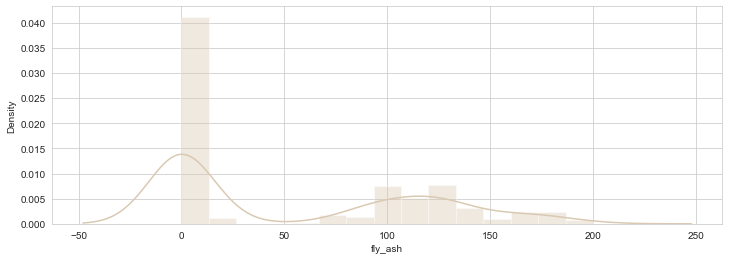

In [15]:
#plot with Zeros
plt.figure(figsize = (12,4))
sns.distplot(a = df['fly_ash'], bins = 15, norm_hist=False, kde=True, color = "#d9c9b2")

📝 If we remove zeros from distribution, we have almost a normal one. mean and median(50%) are too close. may be we should consider zeros as Null Value 🤔

In [16]:
df[df['fly_ash']!=0]['fly_ash'].describe()

count    464.000000
mean     120.286099
std       33.678511
min       24.460000
25%       97.847500
50%      121.350000
75%      141.000000
max      200.100000
Name: fly_ash, dtype: float64

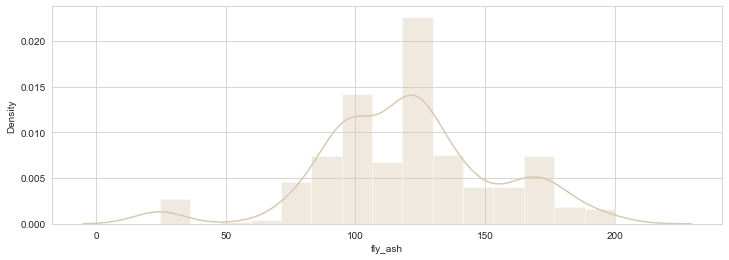

In [17]:
#plot without Zeros
plt.figure(figsize = (12,4))
sns.distplot(a = df[df['fly_ash']!=0]['fly_ash'], bins = 15, norm_hist=False, kde=True, color = "#d9c9b2")

<h2>1-4 Water (kg/m<sup>3</sup>)</h2>

![Predicting concrete strength](img/water.jpg)

📝 It has almost normal shape, mean and median(50%) are too close.It has not zero value.

In [18]:
df["water"].describe()

count    1030.000000
mean      181.566359
std        21.355567
min       121.750000
25%       164.900000
50%       185.000000
75%       192.000000
max       247.000000
Name: water, dtype: float64

In [19]:
print(clr.S+"Zero values:"+clr.E)
sum(list(df['water']==0))

Zero values:


0

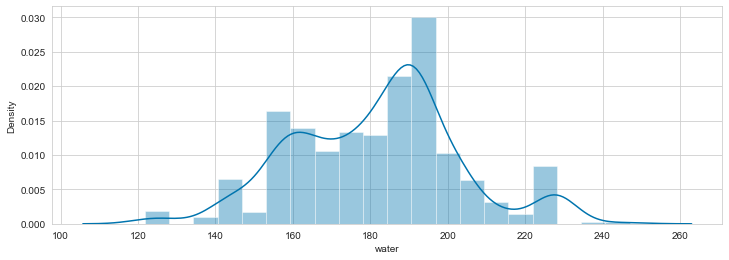

In [20]:
plt.figure(figsize = (12,4))
sns.distplot(a = df['water'], bins = 20, norm_hist=False, kde=True, color = "#0074ae")

<h2>1-5 Superplasticizer(kg/m<sup>3</sup>)</h2>

![Predicting concrete strength](img/Superplasticizer.jpg)

📝 It has left skewed distribution and many zeros.mean and median(50%) are close. 

In [21]:
df['superplasticizer'].describe()

count    1030.000000
mean        6.203112
std         5.973492
min         0.000000
25%         0.000000
50%         6.350000
75%        10.160000
max        32.200000
Name: superplasticizer, dtype: float64

In [22]:
print(clr.S+"Zero values:"+clr.E)
sum(list(df['superplasticizer']==0))

Zero values:


379

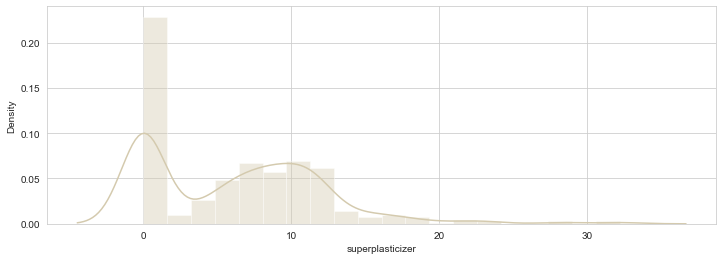

In [23]:
#plot with Zeros
plt.figure(figsize = (12,4))
sns.distplot(a = df['superplasticizer'], bins = 20, norm_hist=False, kde=True, color = "#d4caae")

📝 If we remove zeros from distribution, we have almost normal one again. mean and median(50%) are too close. may be we should leave zero values.

In [24]:
df[df['superplasticizer']!=0]['superplasticizer'].describe()

count    651.000000
mean       9.814447
std        4.581541
min        1.720000
25%        6.930000
50%        9.410000
75%       11.600000
max       32.200000
Name: superplasticizer, dtype: float64

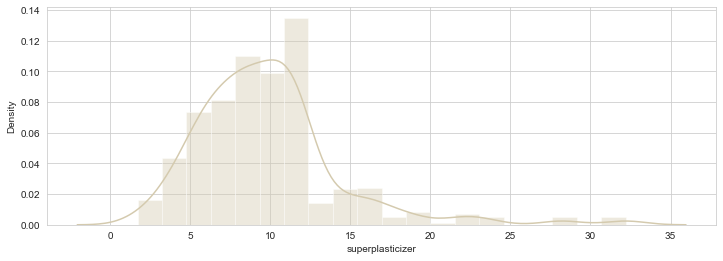

In [25]:
#plot without Zeros
plt.figure(figsize = (12,4))
sns.distplot(a = df[df['superplasticizer']!=0]['superplasticizer'], bins = 20, norm_hist=False, kde=True, color = "#d4caae")

<h2>1-6 Coarse Aggregate(kg/m<sup>3</sup>)</h2>

![Predicting concrete strength](img/Coarse.jpg)

📝 It has almost normal shape, mean and median(50%) are too close.It has not zero value.

In [26]:
df["coarse_aggregate"].describe()

count    1030.000000
mean      972.918592
std        77.753818
min       801.000000
25%       932.000000
50%       968.000000
75%      1029.400000
max      1145.000000
Name: coarse_aggregate, dtype: float64

In [27]:
print(clr.S+"Zero values:"+clr.E)
sum(list(df['coarse_aggregate']==0))

Zero values:


0

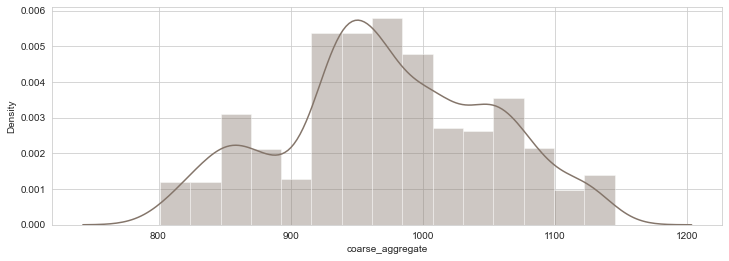

In [28]:
plt.figure(figsize = (12,4))
sns.distplot(a = df['coarse_aggregate'], bins = 15, norm_hist=False, kde=True, color = "#84756a")

<h2>1-7 Fine Aggregate(kg/m<sup>3</sup>)</h2>

![Predicting concrete strength](img/fine.jpg)

📝 It has almost normal shape, mean and median(50%) are too close.It has not zero value.

In [29]:
df["fine_aggregate"].describe()

count    1030.000000
mean      773.578883
std        80.175427
min       594.000000
25%       730.950000
50%       779.510000
75%       824.000000
max       992.600000
Name: fine_aggregate, dtype: float64

In [30]:
print(clr.S+"Zero values:"+clr.E)
sum(list(df['fine_aggregate']==0))

Zero values:


0

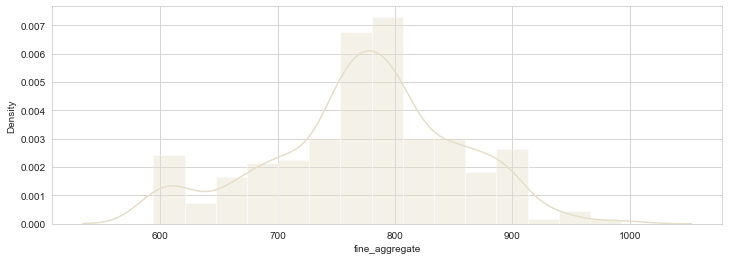

In [31]:
plt.figure(figsize = (12,4))
sns.distplot(a = df['fine_aggregate'], bins = 15, norm_hist=False, kde=True, color = "#e5deca")

<h2>1-8 Age(Days)</h2>

![Predicting concrete strength](img/Age.jpg)

📝 It has left skewed distribution and no zero values.mean and median(50%) are far away because of outliers.

In [32]:
 df["age"].describe()

count    1030.000000
mean       45.662136
std        63.169912
min         1.000000
25%         7.000000
50%        28.000000
75%        56.000000
max       365.000000
Name: age, dtype: float64

In [33]:
print(clr.S+"Zero values:"+clr.E)
sum(list(df['age']==0))

Zero values:


0

📝 If we remove outliers from distribution, we have left skewed one that much closer to normal distribution. mean and median(50%) are close now. may be we should remove outliers or consider them as Null value.

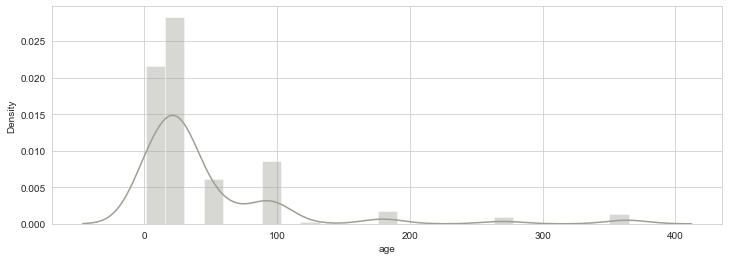

In [34]:
#plot with outliers
plt.figure(figsize = (12,4))
sns.distplot(a = df['age'], bins = 25, norm_hist=False, kde=True, color = "#9c9f94")

In [35]:
df[df["age"]<df["age"].std()*2]["age"].describe()

count    971.000000
mean      32.514933
std       28.616384
min        1.000000
25%        7.000000
50%       28.000000
75%       28.000000
max      120.000000
Name: age, dtype: float64

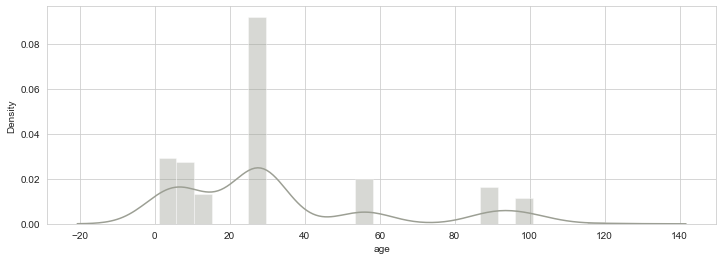

In [36]:
#plot without outliers
plt.figure(figsize = (12,4))
sns.distplot(a = df[df["age"]<df["age"].std()*2]["age"], bins = 25, norm_hist=False, kde=True, color = "#9c9f94")

<h2>1-9 💪Strength(Mpa)</h2>

![Predicting concrete strength](img/Strength.jpg)

📝 It has almost normal shape, mean and median(50%) are too close.It has not zero value.

In [37]:
df["strength"].describe()

count    1030.000000
mean       35.817836
std        16.705679
min         2.331808
25%        23.707115
50%        34.442774
75%        46.136287
max        82.599225
Name: strength, dtype: float64

In [38]:
print(clr.S+"Zero values:"+clr.E)
sum(list(df['strength']==0))

Zero values:


0

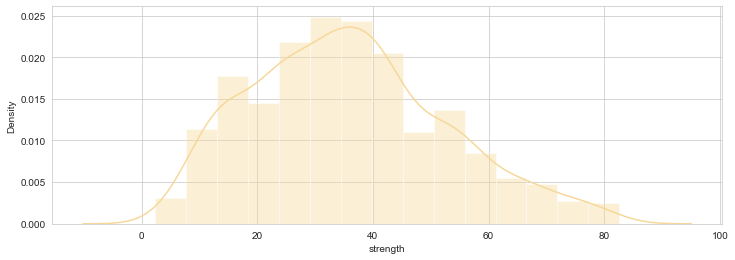

In [39]:
plt.figure(figsize = (12,4))
sns.distplot(a = df['strength'], bins = 15, norm_hist=False, kde=True, color = "#f7d89a")

<h1>2-Compute Correlation Matrix</h1>

📌 let see each of these parameters how impact the strength of concrete.<br>
for very first step, we should see Pearson correlation of each one with strength.<br>
<br><br><br><br>
-Cement is positively correlated with strength(0.49):It so obvious because cement is most important factor in concrete.<br> 
-Superplasticizer is positively correlated with strength (0.36):This element make concrete softer to fill gaps.<br>
-Age is positively correlated with strength (0.32) in third place: older concrete , stronger one<br>
-slag is positively correlated with strength (0.13)<br>
-coarse and fine aggregate are negatively correlated with strength with (-0.16)<br>
-Water is strongly negatively correlated with strength with  (-0.29): It's clear , more water , less strength


In [40]:
corr_cement          =pearsonr(df['cement'],df['strength'])
corr_Slag            =pearsonr(df['slag'],df['strength'])
corr_Flyash          =pearsonr(df['fly_ash'],df['strength'])
corr_Water           =pearsonr(df['water'],df['strength'])
corr_Superplasticizer=pearsonr(df['superplasticizer'],df['strength'])
corr_CoarseAggregate =pearsonr(df['coarse_aggregate'],df['strength'])
corr_FineAggregate   =pearsonr(df['fine_aggregate'],df['strength'])
corr_Age             =pearsonr(df['age'],df['strength'])

print("Cement:            ", corr_cement,"\n"
      "Slag:              ",corr_Slag,"\n"
      "Fly Ash:           ",corr_Flyash,"\n"
      "Water  :           ",corr_Water,"\n"
      "Superplasticizer:  ",corr_Superplasticizer,"\n"
      "Coarse Aggregate:  ",corr_CoarseAggregate,"\n"
      "Fine Aggregate:    ",corr_FineAggregate,"\n"
      "Age:               ",corr_Age)

Cement:             (0.497832722274844, 1.3234579488353072e-65) 
Slag:               (0.13482444514334263, 1.4145749897776599e-05) 
Fly Ash:            (-0.1057533476360821, 0.0006752835596174994) 
Water  :            (-0.28961347569041557, 2.36607269960034e-21) 
Superplasticizer:   (0.3661022976832246, 5.079089236376851e-34) 
Coarse Aggregate:   (-0.16492782105733472, 1.0195972224843314e-07) 
Fine Aggregate:     (-0.1672489619816889, 6.694681482890371e-08) 
Age:                (0.3288769755102851, 2.103144214537607e-27)


<h2>2-1 🔥Heat Map</h2>

✅ We can see above results inside a HeatMap 

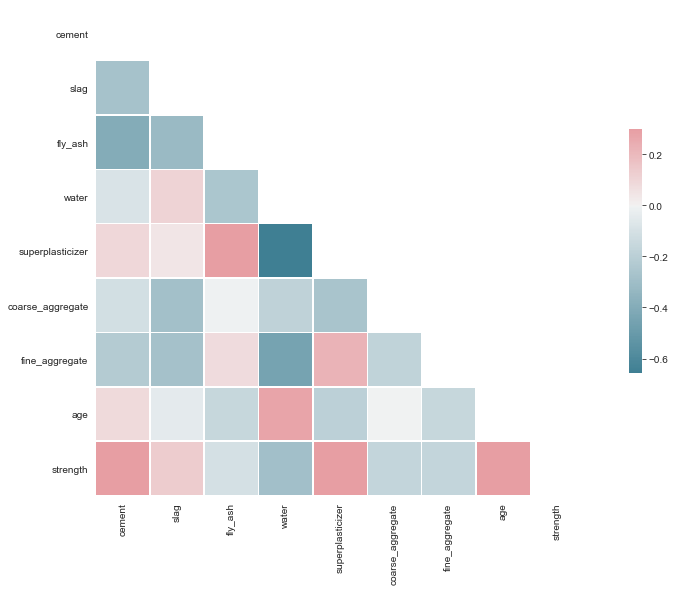

In [41]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

<h1>3-Feature Engineering & Pipleline</h1>

![Predicting concrete strength](img/pipeline.jpg)

📌 As we saw before, it seems that we have not missing value. we can Create our pipeline with standard scaler and linear regression for first step.<br>
But we should remove outliers from our data first. we can do this by our predefined classes ⬇⬇⬇

In [42]:
#remove Outliers
rm=RemoveOutliers()
rm.fit(df)
df=rm.transform(df)
print(clr.S+"The dataset has a size of:"+clr.E, df.shape,clr.S+ "after removing outliers."+clr.E+"\n")

The dataset has a size of: (981, 9) after removing outliers.



In [43]:
#Create Pipeline
steps=[("scaler",StandardScaler()),("model",LinearRegression())]
pl=Pipeline(steps)

#create Features and Target variable
X=df.iloc[:,0:8];y=df.iloc[:,8]

#Run Cross val Score 
cross_validate_pipline(pl,X,y)

The Average Root Mean Squared Error (RMSE)Is: 9.72 and R2 Score: 0.6 With LinearRegression



📌 we can run Random Forest regressor and see importance of each feature and compare them with correlation matrix result.<br>
this help us to make a decision about next model... 

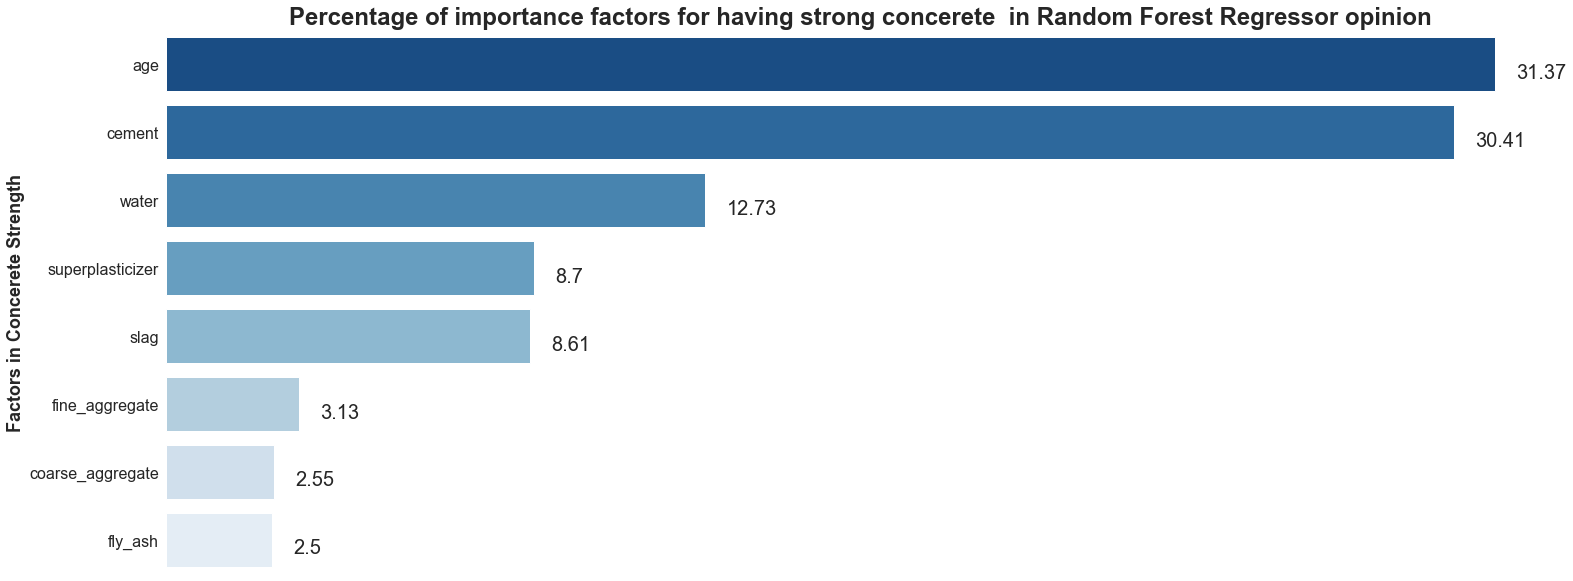

In [44]:
#create Pipline
steps=[("scaler",StandardScaler()),("model",RandomForestRegressor())]
pl=Pipeline(steps)

#run the model
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=20)
pl.fit(X_train,y_train)


#plot important factor in order
importance_rf=pd.Series(pl["model"].feature_importances_,index=X.columns)
sorted_importance_rf=importance_rf.sort_values(ascending=False)
sorted_importance_rf_df=sorted_importance_rf.reset_index()
sorted_importance_rf_df.columns=["Factor","Percent"]
sorted_importance_rf_df
fig, ax = plt.subplots(figsize=(25, 10))
sns.despine(left=True,bottom=True)

sns.barplot(data=sorted_importance_rf_df,x="Percent", y="Factor", palette="Blues_r")

plt.title('Percentage of importance factors for having strong concerete  in Random Forest Regressor opinion ', size=24, weight="bold")
show_values_on_bars(axs=ax, h_v="h", space=0.005)
plt.xlabel("Percentage Of Imporance..")

plt.ylabel("Factors in Concerete Strength", size = 18, weight="bold")
plt.xlabel("")
plt.xticks([])
plt.yticks(size=16)

plt.show()

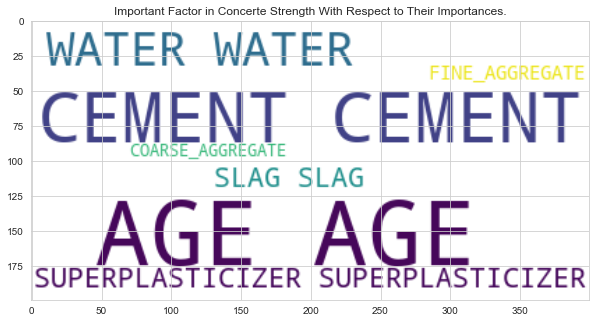

In [45]:
#Create Word Cloud
word_series=(sorted_importance_rf*100).apply(int)
text_cloud=""
for idx in word_series.index:
    text_cloud=text_cloud+(str.upper(idx)+' ')*word_series[idx]
    

wc = WordCloud(background_color="white",   # background of the image
               max_words=7)             # max words to display

wc.generate(text_cloud)

# Plot
fig = plt.figure(figsize=(10, 10))
plt.title("Important Factor in Concerte Strength With Respect to Their Importances.")
plt.imshow(wc, interpolation="bilinear")
plt.show()

📌📌 As we see here, Random forest regressor almost verify the correlation result.

<h1>4-The Challenge Answers</h1>

📌 we have this equation:<br>

👨‍🔬 Strength = β0 + β1 ∗ cement + β2 ∗ slag + β3 ∗ fly ash + β4 ∗ water + β5 ∗ superplasticizer + β6 ∗ coarse aggregate + β7 ∗ fine aggregate + β8 ∗ age.<br>

and we need the coefficients:<br>
we should consider two things:<br>
✔ First: because of existing real value of each factor in equation, we should avoid any scaler. <br>
✔ Second: we should choose our model from Linear Regression Models(Lasso,Ridge, ElasticNet) to obtain these coefficients.

In [46]:
#create Pipline for Ridge
steps=[("model",Ridge())]
pl=Pipeline(steps)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=20)

parameters={"model__alpha":np.arange(0.1,0.7,0.1)}

cv=GridSearchCV(pl,param_grid=parameters,scoring="r2")
cv.fit(X_train,y_train)
print(pl["model"].__class__.__name__,clr.S+"with best alpha parametes:"+clr.E,cv.best_params_["model__alpha"], 
     clr.S+"gives R2 Score:"+clr.E, round(np.mean(cv.best_score_),4),"\n")

Ridge with best alpha parametes: 0.6 gives R2 Score: 0.697 



In [47]:
#create Pipline for ElasticNet
steps=[("model",ElasticNet())]
pl=Pipeline(steps)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=20)

parameters={"model__alpha":np.arange(0.1,0.7,0.1)}

cv=GridSearchCV(pl,param_grid=parameters,scoring="r2")
cv.fit(X_train,y_train)
print(pl["model"].__class__.__name__,clr.S+"with best alpha parametes:"+clr.E,cv.best_params_["model__alpha"], 
     clr.S+"gives R2 Score:"+clr.E, round(np.mean(cv.best_score_),4),"\n")

ElasticNet with best alpha parametes: 0.6 gives R2 Score: 0.6971 



In [66]:
#create Pipline for Lasso
steps=[("model",Lasso())]
pl=Pipeline(steps)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=20)

parameters={"model__alpha":np.arange(0.1,0.7,0.1)}

cv=GridSearchCV(pl,param_grid=parameters,scoring="r2")
cv.fit(X_train,y_train)
print(pl["model"].__class__.__name__,clr.S+"with best alpha parametes:"+clr.E,cv.best_params_["model__alpha"], 
     clr.S+"gives R2 Score:"+clr.E, round(np.mean(cv.best_score_),4),"\n")

Lasso with best alpha parametes: 0.4 gives R2 Score: 0.6971 



📌So, We Choose Lasso with alpha=0.4<br>

In [71]:
score=cross_val_score(cv.best_estimator_,X,y,cv=10,scoring="r2")
print(clr.S+"If we run cross validation score based on winner model, we will have "+clr.E+
      str(round(np.mean(score),2)) +clr.S+" R2 score in average "+clr.E)
score    

If we run cross validation score based on winner model, we will have 0.51 R2 score in average 


array([-0.21997193,  0.78772629,  0.64527372,  0.55278706,  0.41878785,
        0.46318012,  0.71366615,  0.51086279,  0.58532879,  0.59693955])

In [76]:
cross_validate_pipline(cv.best_estimator_,X,y)

The Average Root Mean Squared Error (RMSE)Is: 9.71 and R2 Score: 0.6 With Lasso



<h2>4-1 Average strength<h2>

🧪 You can Enter the Values of the sample Below:

In [49]:
#Cement in kg/m3
cement=540
#Slag in kg/m3
slag=0
#Fly Ash in kg/m3
fly_ash=0
#Water in kg/m3
water=162
#Superplasticizer in kg/m3
superplasticizer=2.5
#Coarse Aggregate in kg/m3
coarse_aggregate=1055
#Fine Aggregate in kg/m3
fine_aggregate=676

# Create Sample DataFrame
sample_DataFrame=pd.DataFrame({"Cement":[cement],"Slag":[slag],"Fly_Ash":[fly_ash],"Water":[water],
                                   "Superplasticizer":[superplasticizer],"Coarse_Aggregate":[coarse_aggregate],
                               "Fine_Aggregate":[fine_aggregate]})

age_sample_list=[1,7,14,28]
sample_result=np.zeros(4)

#See result in age_list
for i,age_sample in enumerate(age_sample_list):
    sample_DataFrame["age"]=age_sample
    sample_result[i]=cv.best_estimator_.predict(sample_DataFrame)
    
print(clr.S+"With below sample factors:\n\n"+clr.E)
print(sample_DataFrame.iloc[0,:7].to_string())    
print(clr.S+"\nwe will have {} average strength in 1,7,14,28 days.".format(round(np.mean(sample_result)),3)+clr.E)


With below sample factors:


Cement               540.0
Slag                   0.0
Fly_Ash                0.0
Water                162.0
Superplasticizer       2.5
Coarse_Aggregate    1055.0
Fine_Aggregate       676.0

we will have 51.0 average strength in 1,7,14,28 days.


<h2>4-2 Coeffients of the equation<h2>

We Can See Coefficients as below:⬇⬇⬇

In [50]:
print("β"+str(0),cv.best_estimator_["model"].intercept_)

for i,coef in enumerate(cv.best_estimator_["model"].coef_):
    print("β"+str(i+1),coef)

β0 -47.40148711363543
β1 0.13042473875169955
β2 0.11556509517679595
β3 0.09571603920726797
β4 -0.13154798577067772
β5 0.3114361420336148
β6 0.02700637551088432
β7 0.025866009837304655
β8 0.2154694216814733


<h1>5-Conclusion<h1>

Based on the challenge that is given, we had limited choice on feature engineering and modeling. we had to keep all features in original format and choose model from linear model to obtain desired coefficients . So evaluation of final result wasn't very nice. however, if we didn't need to these coefficients, would have better options for selecting a model. For example, XGBRegressor without any tuning and with a simple scaler, give us better score.⬇⬇⬇  

In [79]:
#Create Pipeline
steps=[("scaler",StandardScaler()),("model",XGBRegressor(learning_rate = 0.05, n_estimators=1000, random_state=0))]
pl=Pipeline(steps)

#Run Cross val Score 
cross_validate_pipline(pl,X,y)

The Average Root Mean Squared Error (RMSE)Is: 8.55 and R2 Score: 0.65 With XGBRegressor



Thanks every one for reviewing my notebook. Have fun 😊